# 线性支持向量机的朴素实现

+ 虽然从形式上来说，线性支持向量机（LinearSVM）和感知机的差别只在于损失函数，但如果只是简单地将感知机的训练策略（亦即每次只选出使得损失函数最大的样本点来进行梯度下降）迁移过来的话、会引发一些问题。为方便，我们称感知机的训练策略为`极大梯度下降法`（注：这不是被广泛承认的称谓，只是本文的一个代称）
+ 我们会先展示极大梯度下降法的有效性，然后会展示极大梯度下降法存在的问题，最后则会介绍一种解决方案、并将该解决方案拓展为 Mini-Batch 梯度下降法（MBGD）

## 极大梯度下降法训练 LinearSVM

In [1]:
import numpy as np

class LinearSVM:
    def __init__(self):
        self._w = self._b = None
        
    def fit(self, x, y, c=1, lr=0.01, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        self._w = np.zeros(x.shape[1])
        self._b = 0.
        for _ in range(epoch):
            self._w *= 1 - lr
            err = 1 - y * self.predict(x, True)
            idx = np.argmax(err)
            # 注意即使所有 x, y 都满足 w·x + b >= 1
            # 由于损失里面有一个 w 的模长平方
            # 所以仍然不能终止训练，只能截断当前的梯度下降
            if err[idx] <= 0:
                continue
            delta = lr * c * y[idx]
            self._w += delta * x[idx]
            self._b += delta
    
    def predict(self, x, raw=False):
        x = np.asarray(x, np.float32)
        y_pred = x.dot(self._w) + self._b
        if raw:
            return y_pred
        return np.sign(y_pred).astype(np.float32)

### 测试

In [2]:
from Util import gen_two_clusters

x, y = gen_two_clusters()
svm = LinearSVM()
svm.fit(x, y)
print("准确率：{:8.6} %".format((svm.predict(x) == y).mean() * 100))

准确率：   100.0 %


### 可视化

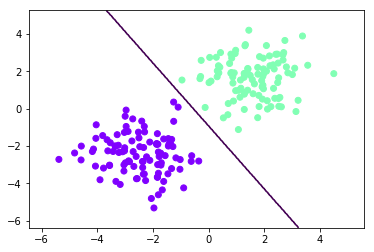

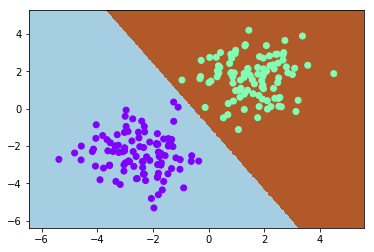

In [3]:
from Util import visualize2d

visualize2d(svm, x, y)
visualize2d(svm, x, y, True)

#### 可视化训练过程

+ 实现思路如下：
    + 在每一步迭代时生成一张如上所示的图像
    + 在最后调用相应的第三方库（`imageio`）、将生成的所有图像合成一个 mp4
    + 用`ffmpeg`将 mp4 转为方便分享的 gif

![LinearSVM](https://cdn.rawgit.com/carefree0910/Resources/f0978da2/Lines/LinearSVM.gif)

![LinearSVM](https://cdn.rawgit.com/carefree0910/Resources/f0978da2/Backgrounds/LinearSVM.gif)

## 存在的问题

+ 由上述可视化其实已经可以看出，用极大梯度下降法训练 LinearSVM 会非常不稳定
+ 从直观上来说，由于 LinearSVM 的损失函数比感知机要更复杂，所以相应的函数形状也会更复杂。这意味着当数据集稍微差一点的时候，直接单纯地应用极大梯度下降法可能会导致一些问题——比如说模型会卡在某个很奇怪的地方无法自拔（什么鬼）

可以通过下面这个栗子来直观感受一下 LinearSVM 存在的这些问题：

准确率：    50.0 %


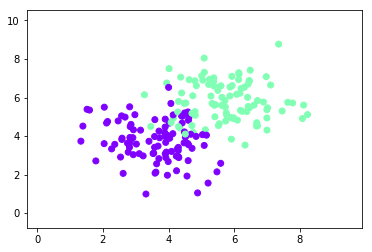

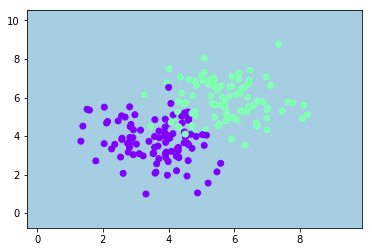

In [4]:
# 注意我们只是把 center 参数（亦即正负样本点的“中心”）
# 从原点(0, 0)（默认值）挪到(5, 5)（亦即破坏了一定的对称性）、
# 并将正负样本点之间的距离（dis 参数）稍微拉近了一点而已，
# 结果就已经惨不忍睹了
x, y = gen_two_clusters(center=5, dis=1)
svm = LinearSVM()
svm.fit(x, y)
print("准确率：{:8.6} %".format((svm.predict(x) == y).mean() * 100))
visualize2d(svm, x, y)
visualize2d(svm, x, y, True)

通过下面这张动图，我们能够直观地感受极大梯度下降法下 LinearSVM 的训练过程：

![Failure of LinearSVM][1]

可以看到，LinearSVM 确实卡在了奇怪的地方

原理我不敢乱说，这里只提供一个牵强附会的直观解释：

+ 每次只取使得损失函数极大的一个样本进行梯度下降$\rightarrow$模型在某个地方可能来来回回都只受那么几个样本的影响$\rightarrow$死循环（什么鬼！）

专业的理论就留待专业的观众老爷补充吧 ( σ'ω')σ

[1]: https://cdn.rawgit.com/carefree0910/Resources/83441596/Lines/LinearSVM(Failed1).gif

## 解决方案

极大梯度下降法的最大问题很有可能在于它每次都只根据**使得损失函数最大的一个样本点**来进行梯度下降，这会导致两个问题：
+ 模型的训练将会很不稳定（这点和随机梯度下降类似）
+ 模型对噪声或“不太好的点”极为敏感（因为它们往往会使损失函数最大）

按部就班、我们先解决第一个问题，为此我们只需要多选出几个样本点（比如选出使得损失函数最大的 top n 个样本）、然后取它们梯度的平均即可

### Top n 梯度下降法

+ 注：该名字同样只是我瞎编的一个名字（喂）

In [5]:
# 继承上一个 LinearSVM 以重复利用代码
class LinearSVM2(LinearSVM):    
    # 用参数 batch_size 表示 Top n 中的 n
    def fit(self, x, y, c=1, lr=0.01, batch_size=128, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        # 如果 batch_size 设得比样本总数还多、则将其改为样本总数
        batch_size = min(batch_size, len(y))
        self._w = np.zeros(x.shape[1])
        self._b = 0.
        for _ in range(epoch):
            self._w *= 1 - lr
            err = 1 - y * self.predict(x, True)
            # 利用 argsort 函数直接取出 Top n
            # 注意 argsort 的结果是从小到大的，所以要用 [::-1] 把结果翻转一下
            batch = np.argsort(err)[-batch_size:][::-1]
            err = err[batch]
            if err[0] <= 0:
                continue
            # 注意这里我们只能利用误分类的样本做梯度下降
            # 因为被正确分类的样本处、这一部分的梯度为 0
            mask = err > 0
            batch = batch[mask]
            # 取各梯度平均并做一步梯度下降
            delta = lr * c * y[batch]
            self._w += np.mean(delta[..., None] * x[batch], axis=0)
            self._b += np.mean(delta)

#### 测试

准确率：    92.5 %


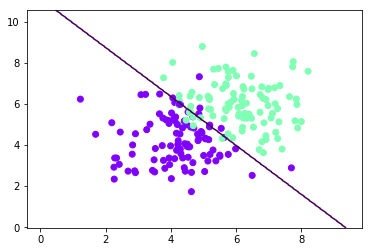

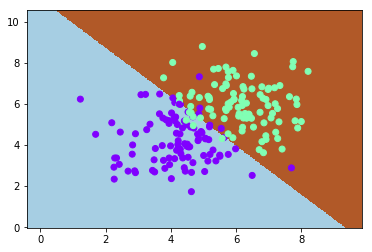

In [6]:
x, y = gen_two_clusters(center=5, dis=1)
svm = LinearSVM2()
svm.fit(x, y)
print("准确率：{:8.6} %".format((svm.predict(x) == y).mean() * 100))
visualize2d(svm, x, y)
visualize2d(svm, x, y, True)

### Mini-Batch 梯度下降法（MBGD）

+ 上述解决方案已经不错，但我们还是有些太“激进”了——我们每次进行梯度下降时，选取的样本点都是使得损失函数最大的样本点，但一般而言使损失函数最大的样本点如果不是关键的样本点（支持向量）的话、通常而言会是噪声。当数据集比较差时，噪声所带来的副作用很有可能就会盖过支持向量带来的正效应
+ 为此，我们应该引入一定的随机性。神经网络的训练中所用的 MBGD 就是很好的方法：每次都从数据集中抽样出一个小 Batch，然后用这个 Batch 来做梯度下降

In [7]:
class LinearSVM3(LinearSVM):
    def fit(self, x, y, c=1, lr=0.01, batch_size=128, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        batch_size = min(batch_size, len(y))
        self._w = np.zeros(x.shape[1])
        self._b = 0.
        for _ in range(epoch):
            self._w *= 1 - lr
            # 随机选取 batch_size 个样本
            batch = np.random.choice(len(x), batch_size)
            x_batch, y_batch = x[batch], y[batch]
            err = 1 - y_batch * self.predict(x_batch, True)
            if np.max(err) <= 0:
                continue
            mask = err > 0
            delta = lr * c * y_batch[mask]
            self._w += np.mean(delta[..., None] * x_batch[mask], axis=0)
            self._b += np.mean(delta)

#### 测试

Top n LinearSVM 准确率：    63.0 %
MBGD  LinearSVM 准确率：    69.0 %


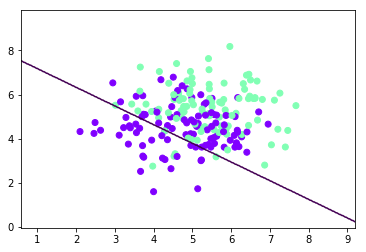

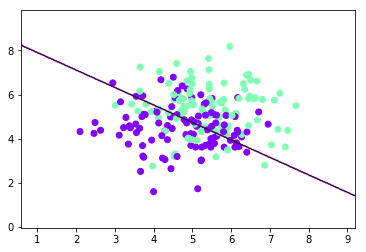

In [8]:
# 进一步拉近正负样本点间的距离以观察性能
x, y = gen_two_clusters(center=5, dis=0.5)
top_n_svm = LinearSVM2()
top_n_svm.fit(x, y)
print("Top n LinearSVM 准确率：{:8.6} %".format((top_n_svm.predict(x) == y).mean() * 100))
mbgd_svm = LinearSVM3()
mbgd_svm.fit(x, y)
print("MBGD  LinearSVM 准确率：{:8.6} %".format((mbgd_svm.predict(x) == y).mean() * 100))

visualize2d(top_n_svm, x, y)
visualize2d(mbgd_svm, x, y)

## 存在的问题

Top n LinearSVM 和 MBGD LinearSVM 各有优劣，很难直接说谁好谁坏；但它们都有一个共同的问题，那就是它们所运用的梯度下降法都只是朴素的`Vanilla Update`，这会导致当数据的 scale 很大时模型对参数极为敏感、从而导致持续的震荡（所谓的 scale 比较大，可以理解为“规模很大”，或者直白一点——以二维数据为例的话——就是横纵坐标的数值很大）

可以通过下面这个栗子来直观感受一下 scale 很大的数据所带来的问题：

Top n LinearSVM 准确率：    50.0 %
MBGD  LinearSVM 准确率：    50.5 %


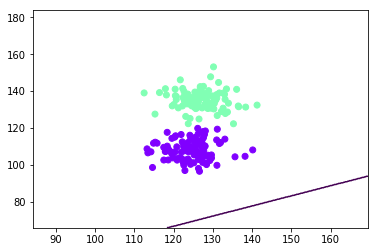

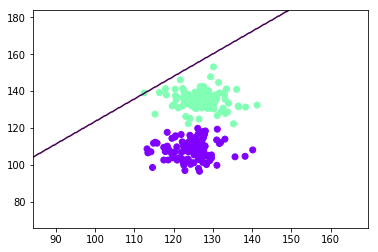

In [9]:
# 将 scale 从 1（默认）调成 5
x, y = gen_two_clusters(center=5, scale=5)
top_n_svm = LinearSVM2()
top_n_svm.fit(x, y)
print("Top n LinearSVM 准确率：{:8.6} %".format((top_n_svm.predict(x) == y).mean() * 100))
mbgd_svm = LinearSVM3()
mbgd_svm.fit(x, y)
print("MBGD  LinearSVM 准确率：{:8.6} %".format((mbgd_svm.predict(x) == y).mean() * 100))

visualize2d(top_n_svm, x, y)
visualize2d(mbgd_svm, x, y)

通过下面这张动图，我们能够直观地感受数据的 scale 很大时 LinearSVM 的训练过程：

![Failure of LinearSVM][2]

可以看到，模型确实一直在持续震荡

[2]: https://cdn.rawgit.com/carefree0910/Resources/83441596/Lines/LinearSVM(Failed2).gif

## 解决方案

+ 采用更好的梯度下降法，比如`Adam`之类的
+ 进行数据预处理、把数据的 scale 弄回 1

关于`Adam`等梯度下降算法的实现和在 LinearSVM 上的应用可以参见[这里](https://github.com/carefree0910/MachineLearning/blob/master/NN/Basic/Optimizers.py)和[这里](https://github.com/carefree0910/MachineLearning/blob/master/e_SVM/LinearSVM.py)，下面我们就仅展示进行数据预处理后的结果

Top 1 LinearSVM 准确率：    98.5 %
Top n LinearSVM 准确率：    97.0 %
MBGD  LinearSVM 准确率：    97.0 %


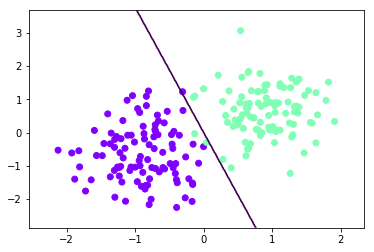

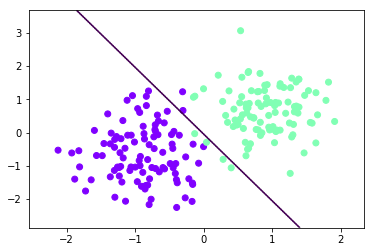

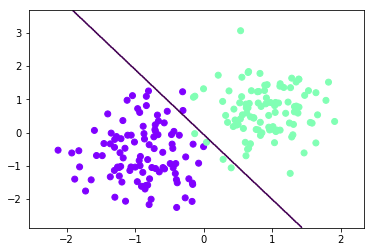

In [10]:
x, y = gen_two_clusters(center=5, dis=1, scale=5)
# 进行归一化处理
x -= x.mean(axis=0)
x /= x.std(axis=0)
# Top 1 梯度下降法即为极大梯度下降法
top_1_svm = LinearSVM()
top_1_svm.fit(x, y)
print("Top 1 LinearSVM 准确率：{:8.6} %".format((top_1_svm.predict(x) == y).mean() * 100))
top_n_svm = LinearSVM2()
top_n_svm.fit(x, y)
print("Top n LinearSVM 准确率：{:8.6} %".format((top_n_svm.predict(x) == y).mean() * 100))
mbgd_svm = LinearSVM3()
mbgd_svm.fit(x, y)
print("MBGD  LinearSVM 准确率：{:8.6} %".format((mbgd_svm.predict(x) == y).mean() * 100))

visualize2d(top_1_svm, x, y)
visualize2d(top_n_svm, x, y)
visualize2d(mbgd_svm, x, y)

可以看到在归一化处理后，即使是简单地采用极大梯度下降法，也能够在比较苛刻的数据（`center=5`、`dis=1`、`scale=5`）上表现得不错